## Face-Recognition

##### References --> 
##### 1.) https://www.geeksforgeeks.org/ml-face-recognition-using-eigenfaces-pca-algorithm/
##### 2.) https://www.youtube.com/watch?v=5HNr_j6LmPc

##### How i trained my own Cascade Classifier using OpenCV? (Given in the README.md) --> https://github.com/Lovepreet-Singh-LPSK/Face-Recognition 

In [62]:
# Importing necessary libraries
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import random
import scipy

## TRAINING :-
#### 1.) Use Viola Jones to detect Faces from images.
#### 2.) Crop Images to Faces Only.
#### 3.) Stack images into an array with images labels in another array. Images then divided into Train and Test.
#### 4.) Calculate Mean Face of training face and substract from each Face.
#### 5.) Calculate Covariance Matrix from that Resulted Matrix.
#### 6.) Calculate eigenvectors and eigenvalues wrt that Covariance Matrix.
#### 7.) Pick top eigenvectors by referring to the top eigenvalues and express each face to the linear combination of the eigenfaces.
#### 8.) Store the weights of the linear combination in array to use later for distance calculation.

In [33]:
#Using Pretrained Cascade classifier for better performance.
face_cascade = cv2.CascadeClassifier(cv2.haarcascades + "haarcascade_frontalface_default.xml")

images = [] #Images to be stored

ndim = (40,40) #Consistent dimension of the images used in all the code

df_faces = pd.read_csv("yalefaces/yalefaces.csv", names = ["Label","x","y","w","h","Path","W","H"])

images_paths = df_faces["Path"].values #Images paths

Labels = df_faces['Label'].values #Images labels for face-rec.

for image_path in (images_paths): 

    img = cv2.imread("yalefaces2/" + image_path, cv2.IMREAD_GRAYSCALE) #Reading image in gray scale
    
    faces = face_cascade.detectMultiScale(img, 1.3, 5) 
    
    if faces != () : #If face is detected using Haarcascade classifier
    
        x,y,w,h = faces[0][0], faces[0][1], faces[0][2], faces[0][3] #Coordinates of the face detected rectangle
    
        img = img[y:y+h, x:x+w] #Face crop for use in eigenFace algo.
    
        img = cv2.resize(img, ndim) #Maintaing consitency in image size
    
        img = np.asarray(img,dtype=float)/255.0 #Normilizing the image pixels
    
        images.append(img.flatten()) #Flat image
    
    else: #If face is not detected store entire image instead of face
    
        img = cv2.resize(img, ndim)
    
        img = np.asarray(img,dtype=float)/255.0
    
        images.append(img.flatten())

In [35]:
# Note:
#     No. of Total Images = 166
#     No. of Training Images = 133
#     No. of Testing Images = 33
#     Dimensions of images = 40*40

In [44]:
def shuffle_split(X, Y): #Randomly shuffling and splitting the data into Train and Test sets
    no_for_test, no_for_train = [], []
    count = 0
    while count != 33: #33 Images for testing
        x = random.randint(0,165)
        if (x in no_for_test) or (x in no_for_train):
            continue
        else:
            no_for_test.append(x)
            count+=1
    count = 0
    while count!=133: #133 Images for training
        x = random.randint(0,165)
        if (x in no_for_train) or (x in no_for_test):
            continue
        else:
            no_for_train.append(x)
            count+=1
    return X[no_for_train,], Y[no_for_train], X[no_for_test,], Y[no_for_test]

images = np.matrix(images) #Change to np array

X, Y = images, Labels

X_train, Y_train, X_test, Y_test = shuffle_split(X,Y)

flattened_images = X_train

A_T = np.matrix(flattened_images)

A = np.transpose(A_T)

X_train.shape , Y_train.shape , X_test.shape, Y_test.shape

((133, 1600), (133,), (33, 1600), (33,))

In [66]:
def ImagesDisplay(images): #Function to display images in 5x5 grid
    fig1, axes = plt.subplots(5, 5)
    fig1.set_size_inches(5, 5)
    k=0
    for row in range(5):
        for col in range(5):    
            im = cv2.resize(images[k],(40,40))
            image_plot = axes[row][col].imshow(im,cmap = plt.cm.gray) 
            axes[row][col].axis('off')
            k = k+1
    plt.show()

mean = np.mean(A, 1) #Mean of stacked flattened images along the column (# Calculating the mean Face)
print("Shape of the mean_image : %d,%d"%mean.shape)

Shape of the mean_image : 1600,1


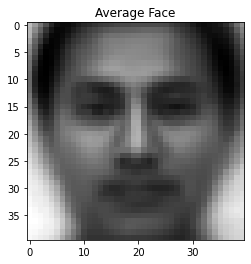

In [48]:
#Mean Face
temp_image = mean.reshape(40,40)
plt.imshow(temp_image, cmap = "gray")
plt.title("Average Face")
plt.show()

In [59]:
# Making the data with mean == 0 (approx). In other words, centring the data for better PCA(Which is effected by the scale).
zero_mean = []
column = 0
# print(flattened_images.shape)
# print(mean.shape)
Zero_mean_matrix = np.ones((1600, 133))
for values in flattened_images:
    zm = A[:,column] - mean
    zm = np.squeeze(zm)
    Zero_mean_matrix[:,column] = zm
    zm_images = zm.resize(40,40)
    zero_mean.append(zm)
    column = column + 1
print(Zero_mean_matrix.shape)

(1600, 133)


In [61]:
d = (np.dot(np.transpose(Zero_mean_matrix),Zero_mean_matrix))/40 #Covariance Matrix with dim. 133x133.
u_list =[] #EigenFaces List
w2, v2 = np.linalg.eigh(d)
print(w2.shape, v2.shape)

# Loop for - Dot Product of the eigenvectors of Average Faces Matrix to obtain Eigen Faces.
# In other words taking a component projection on the eigen vectors for variability.
for ev in v2: 
    ev_transpose = np.transpose(np.matrix(ev))
    u = np.dot(Zero_mean_matrix, ev_transpose) #Dim. of u = 1600x1                           
    u = u / np.linalg.norm(u)
    u_i = u.reshape(40,40)
    u_list.append(u_i) #EigenFaces list
# print(u_i.shape, len(u_list))

(133,) (133, 133)


		k=2


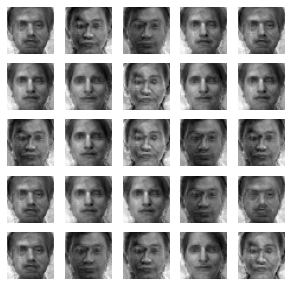

		k=5


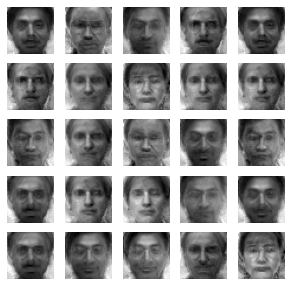

		k=15


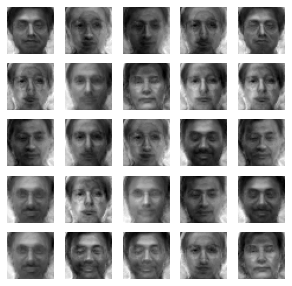

In [67]:
dict = {}

def Reconstruct(k, boolean):
    weights = np.zeros((133,k))
    matrixU = np.zeros((1600,k))
    c = 0
    for val in range(k-1,-1,-1):
        matrixU[:,c] = u_list[val].flatten()
        c = c+1
    rec_face=[]
    for face_num in range(0,133): # Finding Weights of faces
        w = np.dot(np.transpose(matrixU) ,Zero_mean_matrix[:,face_num])
#         print(w.shape)
        #w = Zero_mean_matrix[:,face_num]*np.transpose(matrixU)  
        weights[face_num,:] = w
        #face=np.zeros((1, 180625))
        #         face = np.dot(w[0], matrixU[:,0])
        #         for i in range(1,k):
        #             face = face + np.dot(w[i], matrixU[:,i])
        #         #print(face.shape)
        #         face = face+np.transpose(mean)

        face = np.dot(w, np.transpose(matrixU))
        minf = np.min(face)
        maxf = np.max(face)
        face = face-float(minf)
        face = face/float((maxf-minf))
        face = face+np.transpose(mean)
        reshape_face = face.reshape(40,40)
        rec_face.append(reshape_face)
    if boolean is True:
        ImagesDisplay(rec_face)
    dict[k] = weights

print('\t\tk=2')
Reconstruct(2,True)
print('\t\tk=5')
Reconstruct(5,True)
print('\t\tk=15')
Reconstruct(15,True)

		k=2


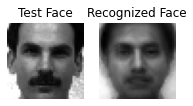

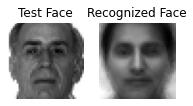

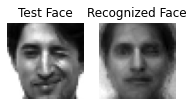

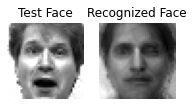

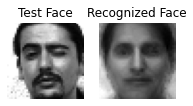

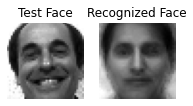

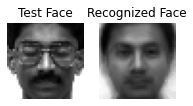

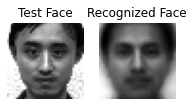

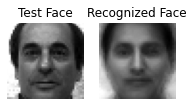

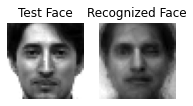

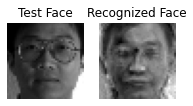

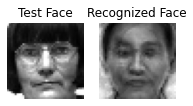

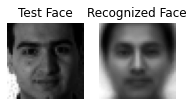

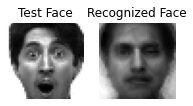

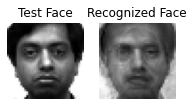

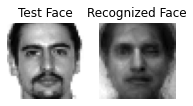

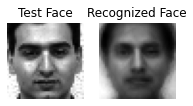

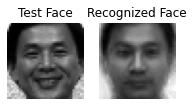

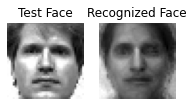

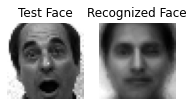

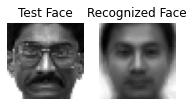

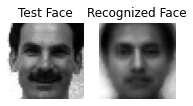

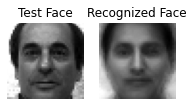

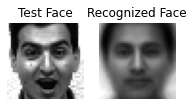

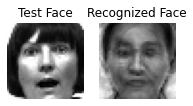

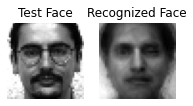

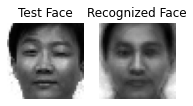

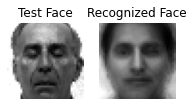

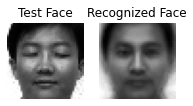

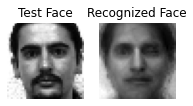

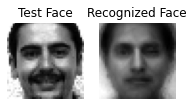

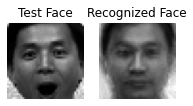

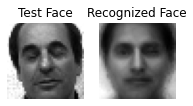

		k=5


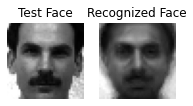

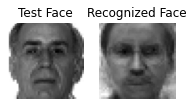

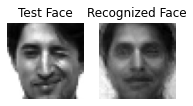

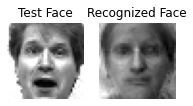

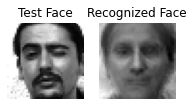

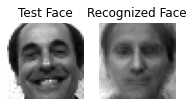

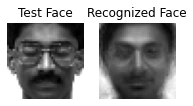

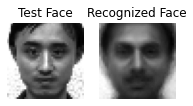

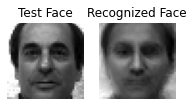

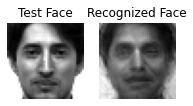

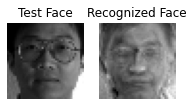

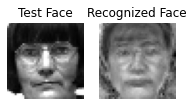

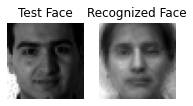

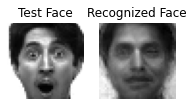

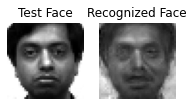

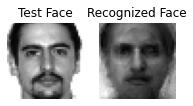

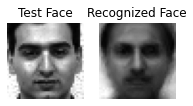

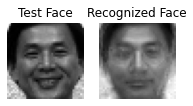

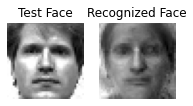

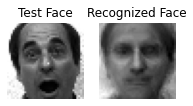

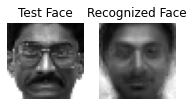

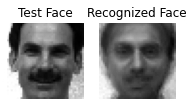

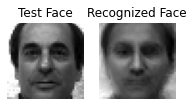

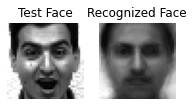

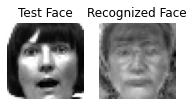

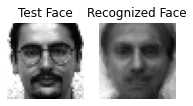

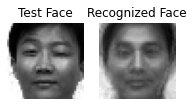

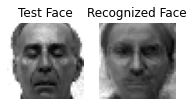

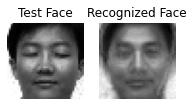

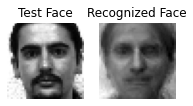

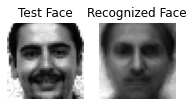

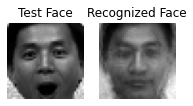

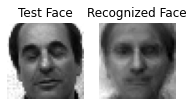

		k=15


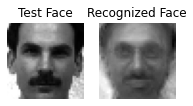

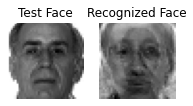

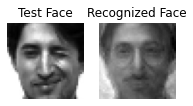

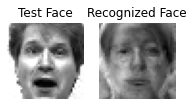

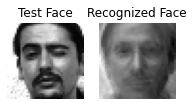

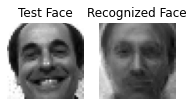

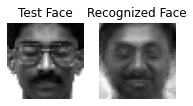

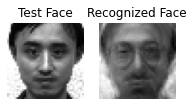

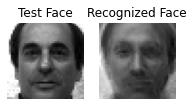

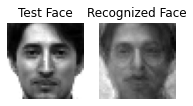

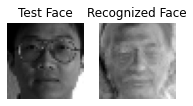

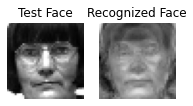

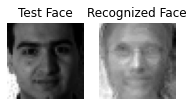

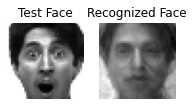

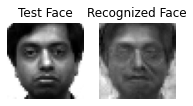

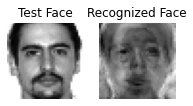

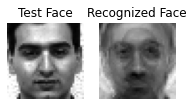

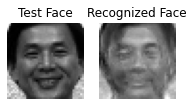

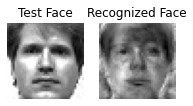

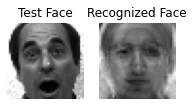

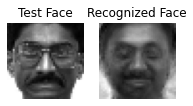

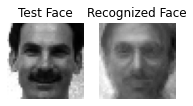

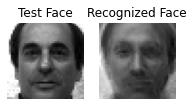

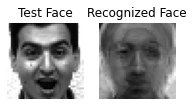

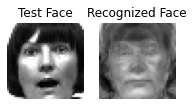

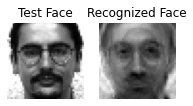

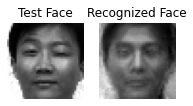

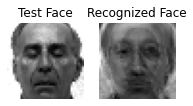

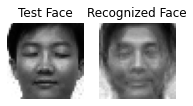

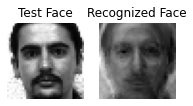

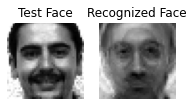

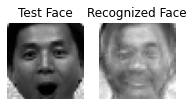

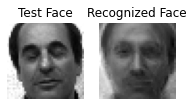

In [78]:
test_images = X_test
def Project(k,zero_mean_test,threshold):
    matrixU = np.zeros((1600,k))
    c = 0
    for val in range(k-1,-1,-1):
        matrixU[:,c] = u_list[val].flatten()
        c = c+1
    w = np.dot(np.transpose(matrixU) ,np.transpose(zero_mean_test))
    original_w_k = dict[k]
    dist =[]
    for wt_vectors in original_w_k:
        dist.append(np.linalg.norm(wt_vectors - w.T))

    nearest_face = np.argmin(dist)
    nearest_face_weights = original_w_k[nearest_face]
    fig1, axes_array = plt.subplots(1, 2)
    fig1.set_size_inches(3,3)
    zero_mean_test = zero_mean_test + np.transpose(mean)
    zero_mean_test = zero_mean_test.reshape(40,40)
    image_plot = axes_array[0].imshow(zero_mean_test,cmap=plt.cm.gray)
    axes_array[0].axis('off')
    axes_array[0].set(title='Test Face')

    face = np.dot(nearest_face_weights, np.transpose(matrixU))
    face = face+np.transpose(mean)
    reshape_face = face.reshape(40,40)
    if np.min(dist)<threshold:  #Nonface
        image_plot = axes_array[1].imshow(reshape_face,cmap=plt.cm.gray)
    axes_array[1].axis('off')
    axes_array[1].set(title ='Recognized Face')
    plt.show()
    
def runs(k):
    for num in range(0,len(test_images)):#t in test_images:
        t = test_images[num]
        test = t.flatten()
        zero_mean_test = test-np.transpose(mean)
        Project(k,zero_mean_test,80)  #threshold =80

print('\t\tk=2')
runs(2)
print('\t\tk=5')
runs(5)
print('\t\tk=15')
runs(15)

In [81]:
test_images = X_test
def Project(k,zero_mean_test,threshold,index):
    matrixU = np.zeros((1600,k))
    c = 0
    for val in range(k-1,-1,-1):
        matrixU[:,c] = u_list[val].flatten()
        c = c+1
    w = np.dot(np.transpose(matrixU) ,np.transpose(zero_mean_test))
    original_w_k = dict[k]
    dist =[]
#     print(w.shape, original_w_k[0].shape)
    
    for count, image_weights in enumerate(original_w_k):
        temp_distance = np.linalg.norm(w-original_w_k[count])
#         print(temp_distance)
        dist.append(temp_distance)
    min_index = np.argmin(dist)
    if Y_train[min_index] == Y_test[index]:
        print(True)
        
def runs(k):
    index = 0
    for num in range(0,len(test_images)):#t in test_images:
        t = test_images[num]
        test = t.flatten()
        zero_mean_test = test-np.transpose(mean)
        Project(k,zero_mean_test,80,index)  #threshold =80
        index+=1
print('\t\tk=5')
runs(2)
print('\t\tk=5')
runs(5)
print('\t\tk=15')
runs(15)

		k=5
True
True
True
True
True
		k=5
True
		k=15
True
True
True
True


# Trying other Code